In [1]:
# 导入必要库
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. 读取数据
data = pd.read_csv('./steel_strength.csv')

# 2. 数据预处理
# 删除非数值列（假设formula列存在）
if 'formula' in data.columns:
    data = data.drop(columns=['formula'])

# 检查缺失值（可选）
print("缺失值统计：")
print(data.isnull().sum())

# 定义特征和标签
X = data.drop(columns=['tensile strength'])  # 特征：所有非拉伸强度列
y = data['tensile strength']                 # 标签：拉伸强度

# 3. 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. 标准化处理
# from sklearn.preprocessing import StandardScaler

# 查看标准化后特征统计量（验证效果）
print("标准化后特征均值：", np.round(X_scaled.mean(axis=0), 2))  # 应接近0
print("标准化后特征方差：", np.round(X_scaled.std(axis=0), 2))   # 应等于1

缺失值统计：
c                   0
mn                  0
si                  0
cr                  0
ni                  0
mo                  0
v                   0
n                   0
nb                  0
co                  0
w                   0
al                  0
ti                  0
yield strength      0
tensile strength    0
elongation          9
dtype: int64
标准化后特征均值： [ 0.  0.  0.  0. -0.  0. -0. -0.  0.  0.  0. -0.  0. -0. nan]
标准化后特征方差： [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. nan]


In [2]:
# 4. 划分数据集
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.2,       # 20%数据作为测试集
    random_state=42      # 固定随机种子确保可复现
)

In [3]:
!pip install shap

Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple
DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


最优参数：{'max_depth': 7, 'max_features': 0.6}


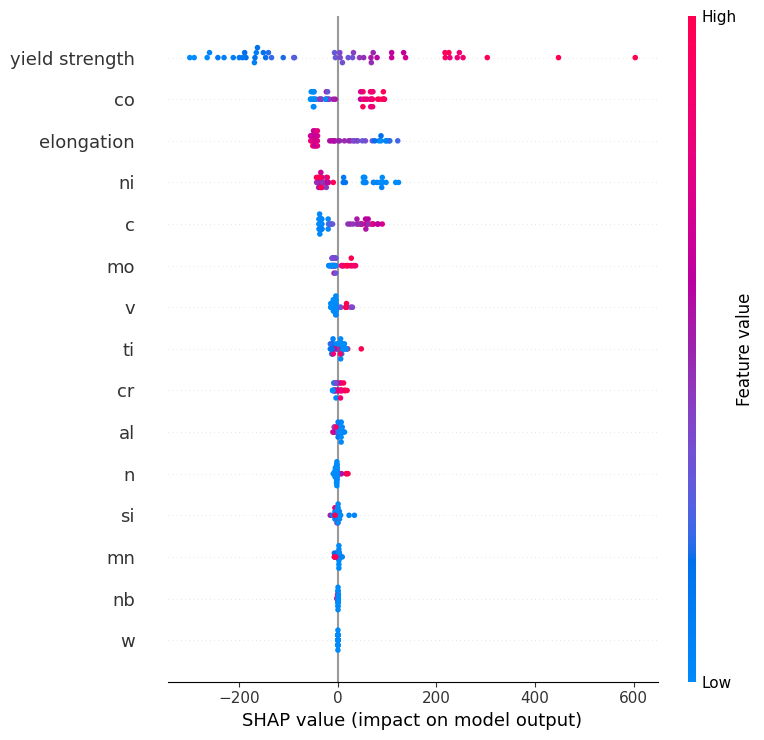

In [4]:
# ===== 1. 随机森林模型构建 =====
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# 基础模型
base_model = RandomForestRegressor(random_state=42)

# ===== 2. 网格搜索优化 =====
param_grid = {
    'max_depth': [3, 5, 7],       # 树深度：控制模型复杂度
    'max_features': ['sqrt', 0.6] # 特征子集规模：防止过拟合
}

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=3,                        # 3折交叉验证
    scoring='neg_mean_squared_error'
)
grid_search.fit(X_train, y_train) # 执行参数搜索

# 获取最优模型
best_model = grid_search.best_estimator_
print(f"最优参数：{grid_search.best_params_}")

# ===== 3. SHAP解释性分析 =====

import shap

# 初始化解释器
explainer = shap.TreeExplainer(best_model)

# 计算SHAP值（抽样50个样本加速计算）
shap_values = explainer.shap_values(X_test[:50])

# 可视化特征贡献度
shap.summary_plot(shap_values, X_test[:50], feature_names=X.columns)


模型性能：
MSE 均方误差: 3896.5
优化后R²: 0.96


Text(0.5, 0, 'SHAP Value Impact (MPa)')

/usr/local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 38190 (\N{CJK UNIFIED IDEOGRAPH-952E}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 32032 (\N{CJK UNIFIED IDEOGRAPH-7D20}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 36129 (\N{CJK UNIFIED IDEOGRAPH-8D21}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph

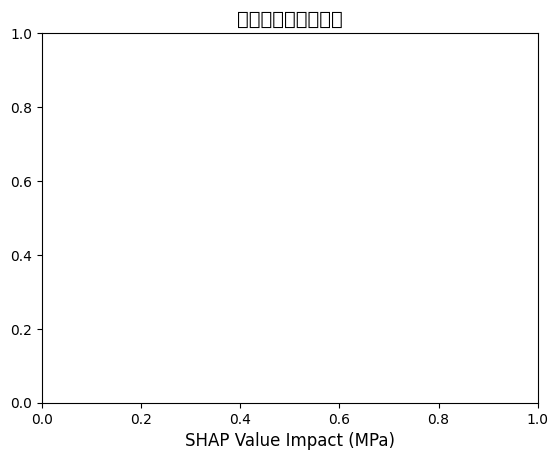

In [7]:
# 模型性能验证
y_pred = best_model.predict(X_test)
print("\n模型性能：")
print(f"MSE 均方误差: {mean_squared_error(y_test, y_pred):.1f}")
print(f"优化后R²: {r2_score(y_test, y_pred):.2f}")

# SHAP可视化输出
plt.title("关键元素贡献度分析", fontsize=14)
plt.xlabel("SHAP Value Impact (MPa)", fontsize=12)

均方误差（MSE）: 3896.5 MPa²
决定系数（R²）: 0.96


/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25289 (\N{CJK UNIFIED IDEOGRAPH-62C9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20280 (\N{CJK UNIFIED IDEOGRAPH-4F38}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24378 (\N{CJK UNIFIED IDEOGRAPH-5F3A}) missing from font(s) DejaVu Sans.
  fig.canvas

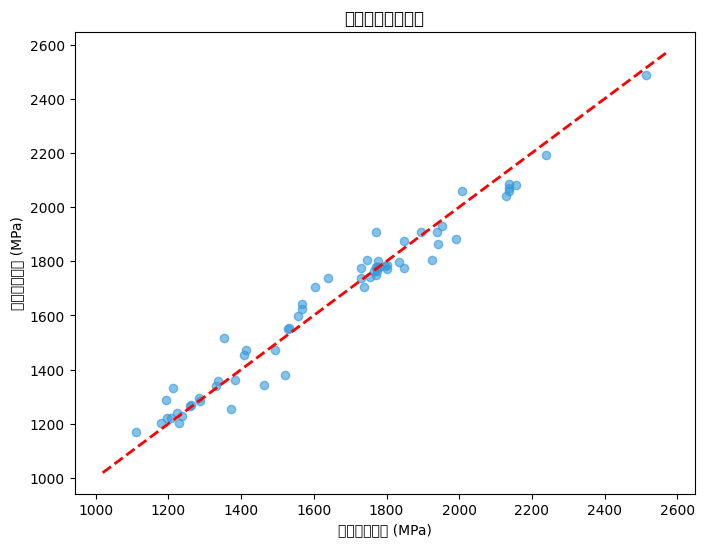

In [6]:
# 导入评估指标库
from sklearn.metrics import mean_squared_error, r2_score

# 预测测试集结果
y_pred = best_model.predict(X_test)  # 使用训练好的模型对测试集进行预测

# 计算均方误差（MSE）
mse = mean_squared_error(y_test, y_pred)  
# MSE = 预测值与真实值差的平方的均值，反映预测误差的绝对大小
# 例如：MSE=8500 表示平均每个预测值与真实值的平方差为8500 MPa²

# 计算决定系数（R²）
r2 = r2_score(y_test, y_pred)  
# R² ∈ [0,1]，表示模型对目标变量的解释能力
# 例如：R²=0.93 表示模型能解释93%的拉伸强度变化

# 输出结果
print(f"均方误差（MSE）: {mse:.1f} MPa²")
print(f"决定系数（R²）: {r2:.2f}")

# 可视化预测效果
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='#3498db')  # 绘制实际值 vs 预测值散点
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)  # 理想对角线（完美预测）
plt.xlabel("实际拉伸强度 (MPa)")
plt.ylabel("预测拉伸强度 (MPa)")
plt.title("模型预测效果对比")
plt.show()